## WGAN-GP Model TF
---

## Import modules

In [1]:
import numpy as np
import pandas as pd
import pickle
import tensorflow as tf
import matplotlib.pyplot as plt
import h5py
from wgangp_model import WGAN_GP

2025-02-27 13:21:25.259119: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-27 13:21:25.266397: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 13:21:25.275055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 13:21:25.277581: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 13:21:25.284193: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [2]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


I0000 00:00:1740658886.984811   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740658887.012294   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740658887.013864   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Load preprocessed data

In [3]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

# Open the HDF5 file
f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

# Combine X_train and X_test
X_transformed = np.concatenate((X_train, X_test), axis=0)
print("Shape of X_transformed:", X_transformed.shape)
np.random.seed(42)
np.random.shuffle(X_transformed)
X_transformed

Shape of X_transformed: (122500, 16)


array([[ 0.2929293 ,  0.47474748,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.        ,  0.6262626 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [-0.47474748,  0.03030303,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.93939394,  0.27272728,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.5555556 , -0.6969697 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.25252524,  0.27272728,  0.        , ...,  0.        ,
         1.        ,  0.        ]], dtype=float32)

In [4]:
X_transformed[0]

array([0.2929293 , 0.47474748, 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        ], dtype=float32)

## Load Preprocessor

In [5]:
# Load the preprocessors and scalers
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

In [6]:
X_tensor = tf.convert_to_tensor(X_transformed, dtype=tf.float32)

# Create a TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices(X_tensor)
batch_size = 30625
dataloader = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

# Example: Iterating through the DataLoader
for batch in dataloader:
    print(batch.shape)

(30625, 16)
(30625, 16)
(30625, 16)
(30625, 16)


I0000 00:00:1740658890.631102   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740658890.634081   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740658890.638190   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740658890.740603   55331 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Train WGANGP
---

In [7]:
# Define model parameters
latent_dim = 128
N_numerical = 2
N_mat_core = len(preprocessor.named_transformers_["cat"].categories_[0])
N_mat_shell = len(preprocessor.named_transformers_["cat"].categories_[1])
batch_size = 256
g_lr = 0.00005
d_lr = 0.00005
beta_1 = 0.5
beta_2 = 0.9
n_critic = 5
n_generator = 1
gradient_penalty_weight = 10
epochs = 1000
sample_interval = 500

In [8]:
# Create and train the WGAN-GP model
wgan_gp = WGAN_GP(
    latent_dim,
    N_numerical,
    N_mat_core,
    N_mat_shell,
    g_lr,
    d_lr,
    beta_1,
    beta_2,
    n_critic,
    n_generator,
    gradient_penalty_weight,
)

/home/dsoun/env/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  0%|          | 1/1000 [00:05<1:24:45,  5.09s/it]

Epoch: 0, Discriminator Loss: 1.1650683879852295, Generator Loss: 0.12016870081424713


 50%|█████     | 502/1000 [01:46<01:39,  4.99it/s]

Epoch: 500, Discriminator Loss: -0.651655912399292, Generator Loss: -0.9214146733283997


100%|██████████| 1000/1000 [03:27<00:00,  4.82it/s]


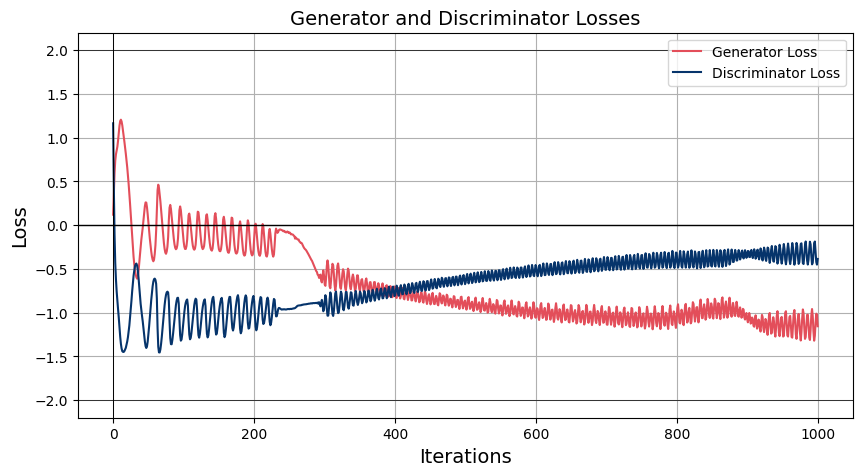

In [9]:
wgan_gp.train(X_transformed, epochs, sample_interval)

# Save the model
wgan_gp.generator.save("models/wgangp_generator.h5")

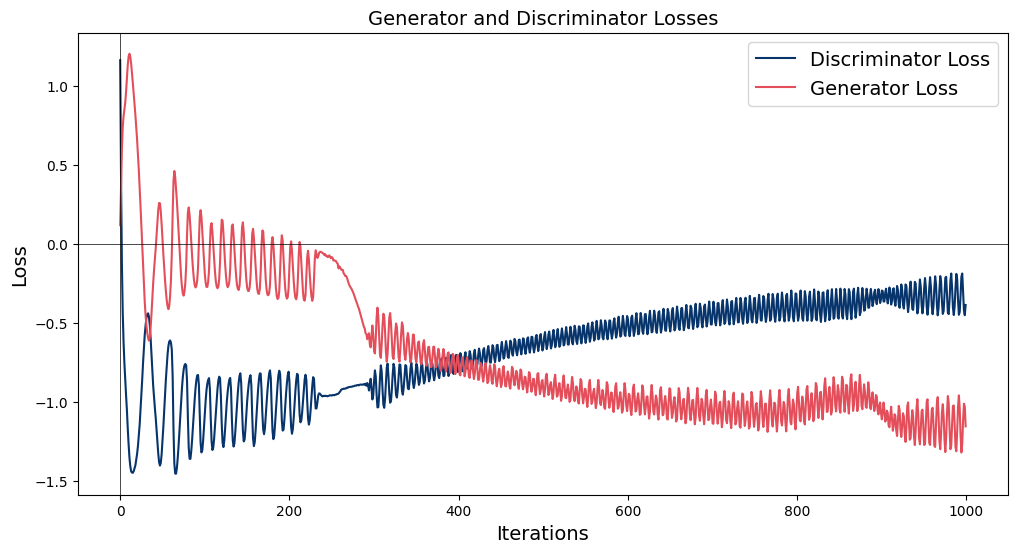

In [10]:
with open("models/wgangp_loss_data.pkl", "rb") as f:
    loss_data = pickle.load(f)

# Extract generator and critic losses
generator_loss = loss_data["generator_loss"]
critic_loss = loss_data["critic_loss"]

# Plot the losses
plt.figure(figsize=(12, 6))
plt.plot(critic_loss, color="#06346B", label="Discriminator Loss")
plt.plot(generator_loss, color="#E34E5A", label="Generator Loss")
plt.axvline(0, color="black", linewidth=0.5)
plt.axhline(0, color="black", linewidth=0.5)
plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.title("Generator and Discriminator Losses", fontsize=14)
plt.legend(fontsize=14, loc="upper right")

plt.show()